In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, backend, constraints, initializers
from keras_self_attention import SeqSelfAttention
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('truncated_LOB_data_BTC_USD_COINBASE.csv')

In [3]:
def finder_of_fulfilment(df, column):
    time, indicator = [], []
    for i in range(len(df)):
        num = df[column].iloc[i]
        arr = df[df[column]>num][column].index
        time.append(pd.to_datetime(df['timestamp'].iloc[arr[arr>i][0]]) - pd.to_datetime(df['timestamp'].iloc[i])
                    if len(arr[arr>i]) else
                    pd.to_datetime('2023-10-03 00:00:00') - pd.to_datetime(df['timestamp'].iloc[i]))
        indicator.append(1 if len(arr[arr>i]) else 0)
    return time, indicator

In [4]:
df['time'], df['indicator'] = finder_of_fulfilment(df, 'ask_prices_0')
df

,timestamp,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,...,bid_prices_3,ask_prices_3,bid_quantity_3,ask_quantity_3,bid_prices_4,ask_prices_4,bid_quantity_4,ask_quantity_4,time,indicator
0,2023-10-02 00:00:00.047811072,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.115522,0.020000,27994.26,...,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504,0 days 00:00:04.287121920,1
1,2023-10-02 00:00:00.199801088,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504,0 days 00:00:04.135131904,1
2,2023-10-02 00:00:00.242750976,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504,0 days 00:00:04.092182016,1
3,2023-10-02 00:00:00.303438848,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27997.99,0.042005,0.001200,27993.73,27998.00,0.186802,0.500000,0 days 00:00:04.031494144,1
4,2023-10-02 00:00:00.395410176,27995.45,27995.46,2.969115,0.420490,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27997.99,0.042005,0.001200,27993.73,27998.00,0.186802,0.500000,0 days 00:00:03.939522816,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103081,2023-10-02 00:10:12.153671936,27968.27,27970.24,0.171501,0.020000,27968.26,27970.25,0.020000,0.053564,27967.98,...,27967.27,27971.29,0.271732,0.214506,27966.76,27971.32,0.452887,0.028795,0 days 23:49:47.846328064,0
103082,2023-10-02 00:10:12.154450944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,27967.98,27971.29,0.072000,0.214506,27967.27,27971.32,0.271732,0.028795,0 days 23:49:47.845549056,0
103083,2023-10-02 00:10:12.158212864,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,27967.98,27971.29,0.072000,0.214506,27967.28,27971.32,0.040000,0.028795,0 days 23:49:47.841787136,0
103084,2023-10-02 00:10:12.158674944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,27967.98,27971.28,0.072000,0.040000,27967.28,27971.29,0.040000,0.214506,0 days 23:49:47.841325056,0


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['time'] = (df['time']).dt.total_seconds().astype(int)
df = df.iloc[0:-140]

In [6]:
df_to_plot = df[['indicator', 'time']]
N = len(df_to_plot)
S_of_t = []

for time in range(max(df['time'])):
    num_executed = len(df_to_plot[df_to_plot['time']==time])
    num_survived = len(df_to_plot[df_to_plot['time']>time])
    prob = num_executed/(num_survived+num_executed)
    #print(prob)
    S_of_t.append(1-prob)

In [7]:
S_hat = np.cumprod(S_of_t)

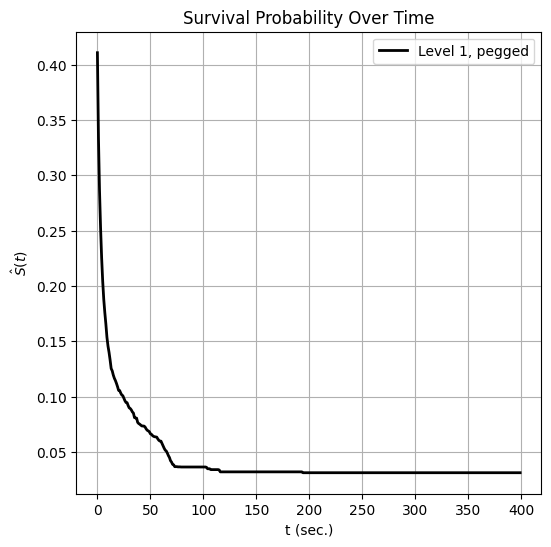

In [8]:
t = np.linspace(0, max(df['time']), max(df['time']))

plt.figure(figsize=(6, 6))
plt.plot(t[:400], S_hat[:400], linewidth=2, label='Level 1, pegged', color='black')
plt.xlabel('t (sec.)')
plt.ylabel('$\hat{S}(t)$')
plt.title('Survival Probability Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
#Make some features and drop useless columns
pd.options.mode.chained_assignment = None

df['vol_imbalance'] = (df['bid_quantity_0'] - df['ask_quantity_0'])/(df['bid_quantity_0'] + df['ask_quantity_0'])
df['microprice'] = ((df['bid_prices_0']*df['bid_quantity_0']+df['ask_prices_0']*df['ask_quantity_0'])
                    /(df['bid_quantity_0'] + df['ask_quantity_0']))

In [10]:
target = [] #create target S(execution_time)
for i in range(len(df)):
    target.append(S_of_t[df['time'].iloc[i]-1])

df['target'] = target

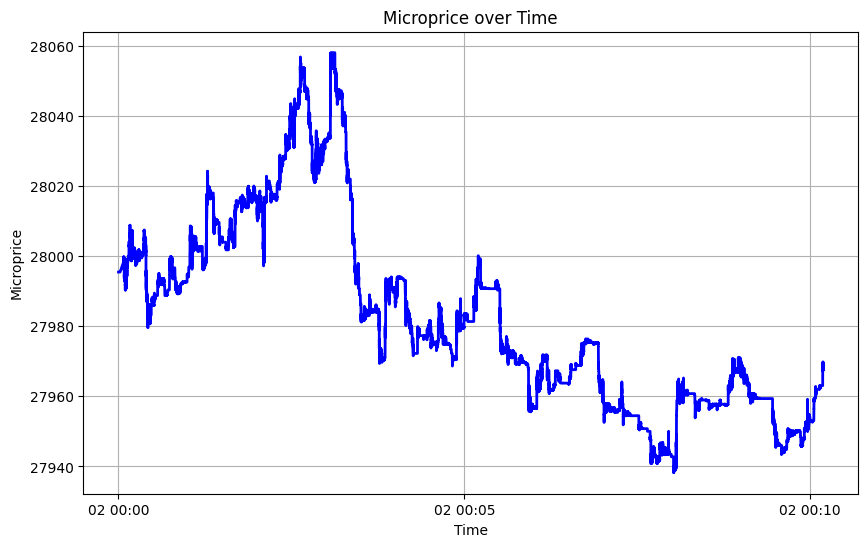

In [11]:
plt.figure(figsize=(10, 6))

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['microprice'], color='blue', linewidth=2, label='Microprice')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Microprice')
plt.title('Microprice over Time')

# Displaying the grid
plt.grid(True)

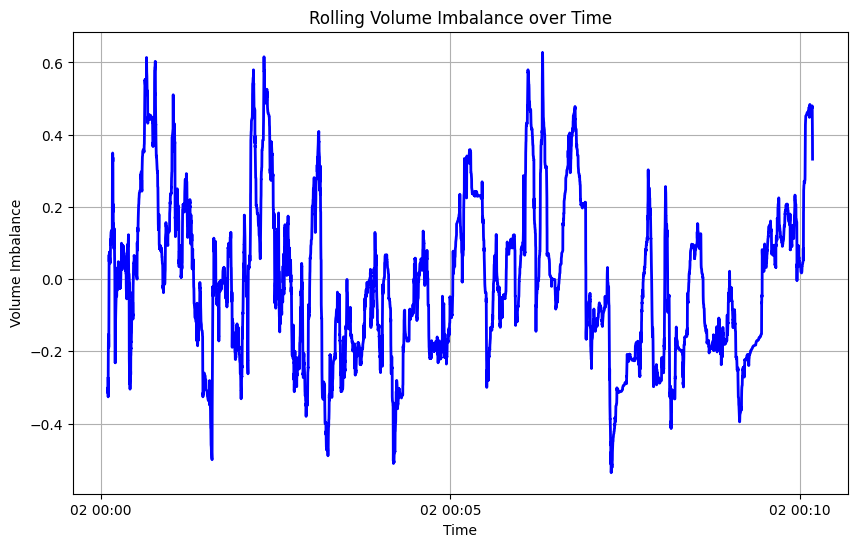

In [12]:
plt.figure(figsize=(10, 6))

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['vol_imbalance'].rolling(1000).mean(), color='blue',
         linewidth=2, label='Rolling Volume Imbalance')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Volume Imbalance')
plt.title('Rolling Volume Imbalance over Time')

# Displaying the grid
plt.grid(True)

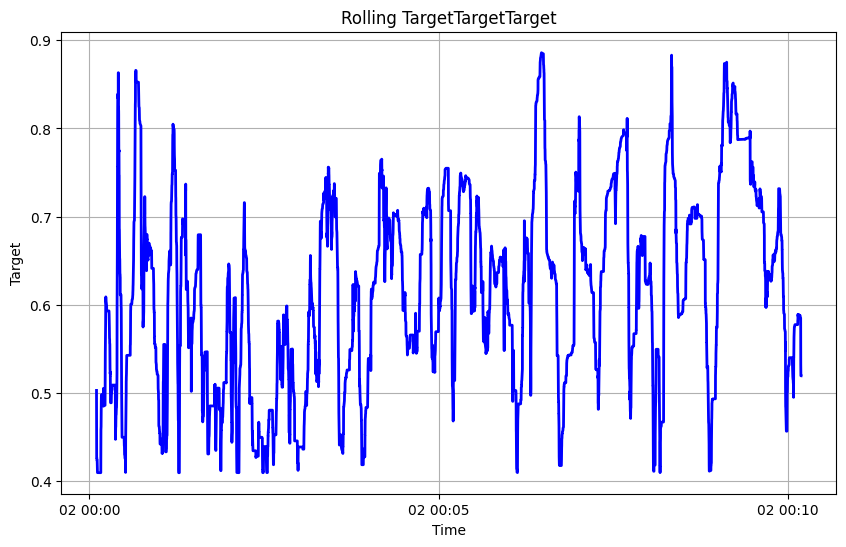

In [13]:
plt.figure(figsize=(10, 6))

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['target'].rolling(1000).mean(), color='blue',
         linewidth=2, label='Target thing')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Target')
plt.title('Rolling TargetTargetTarget')

# Displaying the grid
plt.grid(True)

In [24]:
#df.set_index('timestamp', drop=True, inplace=True)
scaler = StandardScaler()
X = df.drop(columns=['timestamp', 'time', 'indicator', 'target'])
Y = df['target'].iloc[500:].values

In [25]:
tensor_slices = []

for i in range(500, len(X)):
    # Slice the last 100 rows, including the current row
    start_index = max(0, i - 500)  # Adjust index to ensure at least 100 rows
    slice_df = X.iloc[start_index:i+1]

    # Convert the slice to a tensor and append it to the list
    tensor_slice = tf.convert_to_tensor(slice_df, dtype=tf.float32)
    tensor_slices.append(tensor_slice)

# Stack the slices to create a 3D tensor
X = tf.stack(tensor_slices)

print(X.shape)

(102446, 501, 22)


In [26]:
Y.shape

(102446,)

# Simplified Staff (LSTM instead of Att)

In [17]:
input_shape = (100, 22)  # Assuming X is your data
steps = 1  # You need to determine the appropriate number of steps based on your data
encoder_input = layers.Input(shape=input_shape)
encoder_reshape = layers.Reshape(new_input_shape)(encoder_input)
encoder_conv1 = layers.Conv1D(32, kernel_size=2, activation='relu')(encoder_reshape)
encoder_lstm = layers.LSTM(32, activation='relu')(encoder_conv1)
latent_dim = 32
encoder_output = layers.Dense(latent_dim)(encoder_lstm)

encoder_model = Model(encoder_input, encoder_output)

# Define the decoder
decoder_input = layers.Input(shape=(latent_dim,))
decoder_dense1 = layers.Dense(32, activation='relu')(decoder_input)
decoder_reshape = layers.Reshape((1, 32))(decoder_dense1)
decoder_conv1 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(decoder_reshape)
output_dim = 32
decoder_output = layers.Dense(output_dim, activation='sigmoid')(decoder_conv1)

decoder_model = Model(decoder_input, decoder_output)

# Combine the encoder and decoder into an autoencoder
autoencoder_input = layers.Input(shape=input_shape)
encoded = encoder_model(autoencoder_input)
decoded = decoder_model(encoded)
autoencoder_model = Model(autoencoder_input, decoded)

# Compile the model
autoencoder_model.compile(optimizer='adam', loss='MAE')

# Train the model
autoencoder_model.fit(X, Y, epochs=3, batch_size=32)

ValueError: Exception encountered when calling layer "reshape" (type Reshape).

total size of new array must be unchanged, input_shape = [100, 22], output_shape = [100, 1]

Call arguments received by layer "reshape" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 100, 22), dtype=float32)

# Some experiements (model is almost ready monotonicity change is needed or S(t) to f(t) transition)

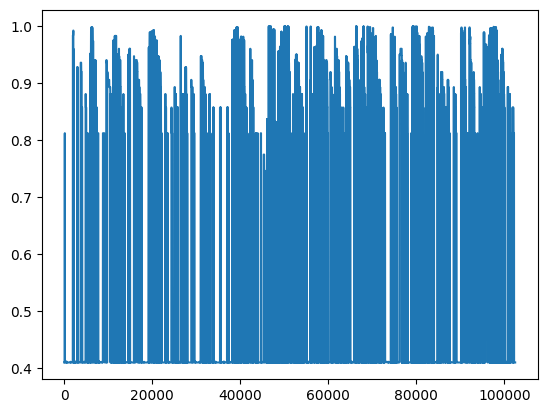

In [27]:
plt.plot(Y)

In [28]:
# Define the DCC layer
class DilatedCausalConvolution(layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate):
        super().__init__()
        self.query_conv = layers.Conv1D(filters=filters, kernel_size=kernel_size,
                                        dilation_rate=dilation_rate, padding='same', activation='sigmoid')
        self.key_conv = layers.Conv1D(filters=filters, kernel_size=kernel_size,
                                      dilation_rate=dilation_rate, padding='same', activation='sigmoid')
        self.value_conv = layers.Conv1D(filters=filters, kernel_size=kernel_size,
                                        dilation_rate=dilation_rate, padding='same', activation='sigmoid')

    def call(self, inputs):
        query = self.query_conv(inputs)
        key = self.key_conv(inputs)
        value = self.value_conv(inputs)
        return query, key, value

# Define the Transformer block
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, d_model):
        super().__init__()
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)

    def call(self, query, key, value):
        attn_output = self.multi_head_attention(query, key, value)
        proj_output = tf.concat(attn_output, axis=0)
        return proj_output

# Define the encoder using the DCC and Transformer block
def create_encoder(input_shape, filters, kernel_size, dilation_rate, num_heads, d_model):
    inputs = layers.Input(shape=input_shape)
    dcc_layer = DilatedCausalConvolution(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate)
    query, key, value = dcc_layer(inputs)
    transformer_block = TransformerBlock(num_heads=num_heads, d_model=d_model)
    transformer_output = transformer_block(query, key, value)
    model = models.Model(inputs=inputs, outputs=transformer_output)
    return model

# Define the monotonic decoder
def monotonic_constraint(weight_matrix):
    return tf.where(weight_matrix < 0, tf.zeros_like(weight_matrix), weight_matrix)

class CustomDense(layers.Layer):
    def __init__(self, units, activation='sigmoid', **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        last_dim = input_shape[-1] if isinstance(input_shape[-1], int) else input_shape[-1].value
        self.kernel = self.add_weight(name='kernel', shape=(last_dim, self.units),
                                      initializer='zeros', constraint=monotonic_constraint, trainable=True)
        self.bias = self.add_weight(name='bias', shape=(self.units,), initializer='zeros', trainable=False)
        super().build(input_shape)

    def call(self, inputs):
        return self.activation(tf.matmul(inputs, self.kernel) + self.bias)

class CustomDecoder(layers.Layer):
    def __init__(self, input_dim, units, activation='sigmoid', num_layers=5, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.dense_layers = [CustomDense(units, activation=activation) for _ in range(num_layers)]
        self.input_dim = input_dim

    def build(self, input_shape):
        self.dense_layers[0].build((None, self.input_dim))

    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        return x

# Combine the encoder and decoder to create the full model
def create_full_model(input_shape, filters, kernel_size, dilation_rate, num_heads, d_model, output_shape, units):
    encoder_inputs = layers.Input(shape=input_shape)
    encoder = create_encoder(input_shape, filters, kernel_size, dilation_rate, num_heads, d_model)
    encoder_output = encoder(encoder_inputs)

    encoder_output_dim = encoder_output.shape[-1]

    decoder = CustomDecoder(input_dim=encoder_output_dim, units=units, activation='sigmoid')
    decoder_output = decoder(encoder_output)
    flat_output = tf.keras.layers.Flatten()(decoder_output)
    final_output = tf.keras.layers.Dense(output_shape)(flat_output)
    full_model = models.Model(inputs=encoder_inputs, outputs=final_output)

    return full_model

In [32]:
# Define model parameters
input_shape = (501, 22)  # Adjust based on your actual data dimensions
filters = 64
units = 32
kernel_size = 32
dilation_rate = 1
num_heads = 3
d_model = 64
output_shape = 1  # Adjust based on your output dimensions

In [ ]:
# Create the model
model = create_full_model(input_shape, filters, kernel_size, dilation_rate, num_heads, d_model, output_shape, units)

# Create TensorFlow dataset
train_ds = tf.data.Dataset.from_tensor_slices((X, Y)).batch(32)

# Compile the model
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.MeanAbsoluteError())

# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
model.fit(train_ds, epochs=1000, callbacks=[callback])

Epoch 1/1000
3202/3202 [==============================] - 661s 206ms/step - loss: 7.3073
Epoch 2/1000
2451/3202 [=====================>........] - ETA: 23:29 - loss: 6.5381

In [22]:
Y_pred = model.predict(X)

Y_pred.mean()

3214/3214 [==============================] - 51s 16ms/step


0.43839782

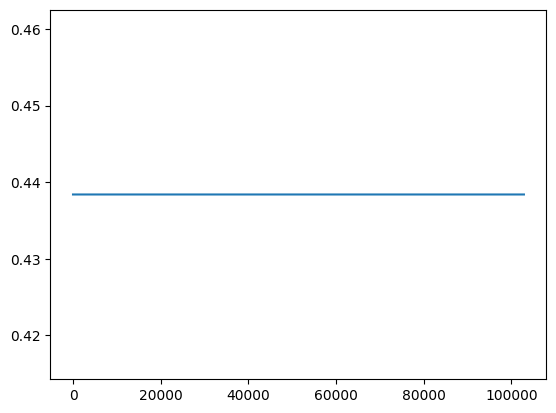

In [23]:
plt.plot(Y_pred)

In [ ]:
Y

In [ ]:
model_att.add(SeqSelfAttention(units=1, attention_activation='sigmoid', attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL, input_shape=(X.shape[1], 1)))
model_att.add(layers.Flatten())
model_att.add(layers.Dense(1, activation='linear'))
model_att.compile(loss='mae', optimizer='adam')
history = model_att.fit(X, Y, epochs=100, verbose=2)

In [ ]:
SeqSelfAttention.